In [109]:
import pandas as pd
from allocations import Allocations
import matplotlib.pyplot as plt
import numpy as np

In [111]:
methods = [
    "fasterrisk",
    "bootstrap_nn",
    "nn_variance",
    "awp"]

labels = [
    "Feature Selection",
    "Training Data",
    "Training Initialization",
    "Weight Perturbation"
]
SELECTION_RATE = 0.25
QUALIFICATION_COLUMN = "qualified_gagne_2"
ITERATIONS_PER_SPLIT = 25
TEST_SIZE = 1000
RASHOMON_EPSILON = 0.01

USE_BEST = True

output_file = "viz/sickness_ratio.jpg"
if USE_BEST:
    output_file = "viz/sickness_ratio_best.jpg"
data = pd.read_csv("data/obermeyer/obermeyer_data_cleaned.csv")

In [112]:
def add_rank(group):
    group["rank"] = range(len(group))
    return group

In [115]:
all_results = []
baseline = []

for m in methods:
    print(m)
    #df = pd.read_csv("results/"+m+"_"+QUALIFICATION_COLUMN+".csv")
    df = pd.read_csv("fasterrisk_qualified_gagne_2.csv")
    a = Allocations(df, TEST_SIZE, SELECTION_RATE, "y", RASHOMON_EPSILON, ITERATIONS_PER_SPLIT)
    allocations, people = a.get_allocations()

    results = []
    for seed in allocations["seed"].unique():
        for iteration in allocations["iteration"].unique():
            curr_people = list(people.loc[((people["seed"]==seed)&(people["iteration"]==iteration)), "people"])[0]
            test_data = data.loc[data["person_id"].isin(curr_people), ["person_id", QUALIFICATION_COLUMN, "race", "gagne_sum_t"]]
    
            curr_allocations = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "selected"].to_list()
            for a in curr_allocations:
                feature_group_num = test_data.loc[(test_data["race"]==1)&(test_data["person_id"].isin(a)), "gagne_sum_t"].mean()
                feature_group_denom = test_data.loc[(test_data["race"]==0)&(test_data["person_id"].isin(a)), "gagne_sum_t"].mean()
                results.append(feature_group_num / feature_group_denom)
            
            # Baseline Simulations
            k_prime = int(np.round(allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "k'"].mean()))
            k_minus_k_prime = int(TEST_SIZE*SELECTION_RATE) - k_prime

            if USE_BEST:
                qualified = test_data[(test_data[QUALIFICATION_COLUMN]==1)].groupby(["gagne_sum_t", "race"], group_keys=False).apply(add_rank)
                qualified = qualified.sort_values(by=["gagne_sum_t", "rank"], ascending=[False, True]).drop(columns="rank").reset_index(drop=True)
                unqualified = test_data[(test_data[QUALIFICATION_COLUMN]==0)].groupby(["gagne_sum_t", "race"], group_keys=False).apply(add_rank)
                unqualified = unqualified.sort_values(by=["gagne_sum_t", "rank"], ascending=[False, True]).drop(columns="rank").reset_index(drop=True)
                selected = pd.concat([qualified.loc[:k_prime], unqualified.loc[:k_minus_k_prime]])
                g1_f = np.mean(selected.loc[selected["race"]==1, "gagne_sum_t"])
                g2_f = np.mean(selected.loc[selected["race"]==0, "gagne_sum_t"])
                baseline.append(g1_f/g2_f)
            else:
                qualified = test_data[test_data[QUALIFICATION_COLUMN]==1]
                unqualified = test_data[test_data[QUALIFICATION_COLUMN]==0]
                for i in range(100):
                    selected = pd.concat([qualified.sample(n=k_prime), unqualified.sample(n=k_minus_k_prime)])
                    feature_group_num = selected.loc[(selected["race"]==1), "gagne_sum_t"].mean()
                    feature_group_denom = selected.loc[(selected["race"]==0), "gagne_sum_t"].mean()
                    baseline.append(feature_group_num / feature_group_denom)
    all_results.append(results)

fasterrisk
bootstrap_nn
nn_variance
awp


In [116]:
all_results.append(baseline)
all_results.reverse()
labels.reverse()

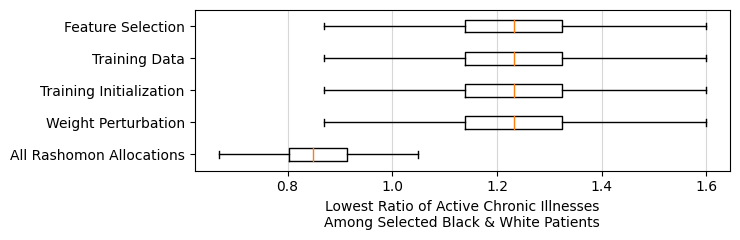

In [117]:
fig, ax = plt.subplots(figsize=(7.5,2.5))
bp_dict = ax.boxplot(all_results, showfliers=False, vert=False, notch=False, widths=0.4)

ax.set_yticklabels(["All Rashomon Allocations"]+labels)

if USE_BEST:
    ax.set_xlabel("Lowest Ratio of Active Chronic Illnesses\nAmong Selected Black & White Patients")
else:
    ax.set_xlabel("Ratio of Active Chronic Illnesses\nAmong Selected Black & White Patients")

plt.grid(True, axis='x', alpha=0.5)
fig.tight_layout()
fig.savefig(output_file, dpi=500)